In [68]:
import cv2
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from torchvision import transforms as trans
import itertools, random, copy, os
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from dataloader import DatasetValidation
from models import Backbone
import torch.nn.functional as F

In [2]:
def create_pairs(id_list, path, k_pairs):
    list_pairs = []
    for id in id_list:
        imgs_list = os.listdir(path+id)
        if len(imgs_list)>1:
            tmp = list(itertools.combinations(imgs_list, 2))
            tmp = [((id+'/'+t[0], id+'/'+t[1]),  True) for t in tmp]
            if len(tmp)>=k_pairs:
                tmp = random.sample(tmp, k_pairs)
            else:
                tmp = random.sample(tmp, len(tmp))
            list_pairs+=tmp
        
        copy_id_list = copy.copy(id_list)
        copy_id_list.remove(id)
        #random_id = random.choice(copy_id_list)
        #random_id_imgs = os.listdir('./cropped_img_celeba/'+random_id)
        tmp2 = []
        for i in range(k_pairs):
            random_id = random.choice(copy_id_list)
            random_id_imgs = os.listdir(path+random_id)
            rch_1 = random.choice(imgs_list)
            rch_2 = random.choice(random_id_imgs)
            tmp2.append(((id+'/'+rch_1, random_id+'/'+rch_2), False))
        list_pairs+=tmp2
    return list_pairs

In [3]:
id_list = os.listdir('/data/beybars_id/img_data/cropped_alligned_val/')
list_pairs = create_pairs(id_list, '/data/beybars_id/img_data/cropped_alligned_val/', 6)

In [5]:
len(list_pairs)

240000

In [8]:
val_dataset = DatasetValidation(list_pairs, '/data/beybars_id/img_data/cropped_alligned_val/')
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=2)

In [9]:
a = next(iter(val_dataloader))

In [11]:
a.keys()

dict_keys(['IMG_1_NAME', 'IMG_1', 'IMG_2_NAME', 'IMG_2', 'isSame'])

In [19]:
torch.cuda.set_device(3)

In [20]:
torch.cuda.current_device()

3

In [23]:
model = Backbone(50, 0.6, 'ir_se').to('cuda:3')

In [26]:
snapshot = torch.load('./workspace/steps_models_save/model_2023-02-08-03-39_accuracy:0.9972624999999999_epoch:6_step:153300_None.pth',
                      map_location='cuda:3')

In [29]:
model.load_state_dict(snapshot['MODEL_STATE'])

<All keys matched successfully>

In [51]:
model.eval()
print("Validation...")
emb_list_1 = []
emb_list_2 = []
isSame_list = []#################################################
with torch.no_grad():
    for val_batch in val_dataloader:
        imgs_1 = val_batch['IMG_1']
        imgs_2 = val_batch['IMG_2']
        isSame = val_batch['isSame']
        imgs_1 = imgs_1.to('cuda:3')
        imgs_2 = imgs_2.to('cuda:3')
        embeddings_1 = model(imgs_1)
        embeddings_2 = model(imgs_2)
        embeddings_normed_1 = F.normalize(embeddings_1)
        embeddings_normed_2 = F.normalize(embeddings_2)
        embeddings_normed_1 = embeddings_normed_1.detach().cpu()
        embeddings_normed_2 = embeddings_normed_2.detach().cpu()
        emb_list_1.append(embeddings_normed_1)
        emb_list_2.append(embeddings_normed_2)
        isSame_list+=isSame#################################################
    embeddings_tensor_1 = torch.vstack(emb_list_1)
    embeddings_tensor_2 = torch.vstack(emb_list_2)
    

Validation...


NameError: name 'nrof_folds' is not defined

In [80]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import sklearn, torch
from scipy import interpolate


def calculate_roc(thresholds, embeddings_tensor_1, embeddings_tensor_2, isSame, sim_metric, nrof_folds):
    assert(embeddings_tensor_1.shape[0] == embeddings_tensor_2.shape[0])
    assert(embeddings_tensor_1.shape[1] == embeddings_tensor_2.shape[1])

    nrof_pairs = len(isSame)
    nrof_thresholds = len(thresholds)
    #print(nrof_folds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds, nrof_thresholds))
    tnrs = np.zeros((nrof_folds, nrof_thresholds))
    fprs = np.zeros((nrof_folds, nrof_thresholds))
    fnrs = np.zeros((nrof_folds, nrof_thresholds))
    
    tp = np.zeros((nrof_folds, nrof_thresholds))
    tn = np.zeros((nrof_folds, nrof_thresholds))
    fp = np.zeros((nrof_folds, nrof_thresholds))
    fn = np.zeros((nrof_folds, nrof_thresholds))
    
    accuracy_test = np.zeros((nrof_folds))
    accuracy_train = np.zeros((nrof_folds, nrof_thresholds)) #################################################
    best_thresholds = np.zeros((nrof_folds))
    indices = np.arange(nrof_pairs)

    if sim_metric=='cosine_sim':
        cos_sim = np.dot(embeddings_tensor_1, embeddings_tensor_2)
    elif sim_metric=='euclidean_dis':
        diff = np.subtract(embeddings_tensor_1, embeddings_tensor_2)
        dist = np.square(diff).sum(axis=1)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the best threshold for the fold
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, _, _, accuracy_train[fold_idx, threshold_idx], _ = calculate_accuracy(threshold, dist[train_set], isSame[train_set])
        #best_threshold_index = np.argmax(accuracy_train)
        best_threshold_index = np.argmax(accuracy_train[fold_idx])
        best_thresholds[fold_idx] = thresholds[best_threshold_index]
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx, threshold_idx], tnrs[fold_idx, threshold_idx],\
            fprs[fold_idx, threshold_idx], fnrs[fold_idx, threshold_idx], _, conf_mat = calculate_accuracy(threshold,\
                                                                                                dist[test_set],\
                                                                                                isSame[test_set])
            tp[fold_idx, threshold_idx] = conf_mat[0]
            tn[fold_idx, threshold_idx] = conf_mat[1]
            fp[fold_idx, threshold_idx] = conf_mat[2]
            fn[fold_idx, threshold_idx] = conf_mat[3]
            
        _, _, _, _, accuracy_test[fold_idx], _ = calculate_accuracy(thresholds[best_threshold_index],\
                                                                            dist[test_set],\
                                                                            isSame[test_set])
    tpr = np.mean(tprs, 0)
    tnr = np.mean(tnrs, 0)
    fpr = np.mean(fprs, 0)
    fnr = np.mean(fnrs, 0)
    
    tp = np.mean(tp, 0)
    tn = np.mean(tn, 0)
    fp = np.mean(fp, 0)
    fn = np.mean(fn, 0)
    
    return tpr, tnr, fpr, fnr, accuracy_test, best_thresholds, tp, tn, fp, fn


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    predict_issame_bool = predict_issame.clone().detach().numpy()

    # print(predict_issame[:5])
    # print()
    # print(actual_issame[:5])
    TP = np.sum(np.logical_and(predict_issame_bool, actual_issame))
    FP = np.sum(np.logical_and(predict_issame_bool, np.logical_not(actual_issame)))
    TN = np.sum(np.logical_and(np.logical_not(predict_issame_bool), np.logical_not(actual_issame)))
    FN = np.sum(np.logical_and(np.logical_not(predict_issame_bool), actual_issame))
    
    TPR = 0 if (TP + FN == 0) else float(TP) / float(TP + FN)
    TNR = 0 if (TN + FP == 0) else float(TN) / float(TN + FP)
    FPR = 0 if (FP + TN == 0) else float(FP) / float(FP + TN)
    FNR = 0 if (FN + TP == 0) else float(FN) / float(FN + TP)
    acc = float(TP + TN)/dist.shape[0]
    return TPR, TNR, FPR, FNR, acc, (TP, TN, FP, FN)


def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10):
    '''
    Copy from [insightface](https://github.com/deepinsight/insightface)
    :param thresholds:
    :param embeddings1:
    :param embeddings2:
    :param actual_issame:
    :param far_target:
    :param nrof_folds:
    :return:
    '''
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff), 1)
    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train) >= far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    torch.tensor(a, dtype=torch.bool)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far


def evaluate_metrics(embeddings_tensor_1, embeddings_tensor_2, isSame, sim_metric, nrof_folds=5):
    thresholds = np.arange(0, 4, 0.01)
    tpr, tnr, fpr, fnr, accuracy_test, best_thresholds, tp, tn, fp, fn = calculate_roc(thresholds,\
                                                                                   embeddings_tensor_1,\
                                                                                   embeddings_tensor_2,\
                                                                                   np.asarray(isSame),\
                                                                                   sim_metric,\
                                                                                   nrof_folds=nrof_folds
                                                                                  )
    return tpr, tnr, fpr, fnr, accuracy_test, best_thresholds, tp, tn, fp, fn

In [81]:
TPR, TNR, FPR, FNR, accuracy, best_thresholds, tp, tn, fp, fn = evaluate_metrics(embeddings_tensor_1, embeddings_tensor_2,\
                                                                                     isSame_list, 'euclidean_dis', 3)


In [82]:
thresholds = np.arange(0, 4, 0.01)
for thr in best_thresholds:
    indx=np.where(thresholds == thr)
    ind = indx[0].item()
    precision = tp[ind]/(tp[ind]+fp[ind])
    recall = tp[ind]/(tp[ind]+fn[ind])
    fraud = tn[ind]/(tn[ind]+fp[ind])
    print('threshold:{},\n precision:{},\n recall:{},\n fraud_det:{}'.format(thr, precision, recall, fraud))
    print()
from sklearn import metrics
auc_roc = metrics.auc(TPR, FPR)
print(auc_roc)

threshold:1.47,
 precision:0.9996902806726768,
 recall:0.9952166666666666,
 fraud_det:0.9996916666666666

threshold:1.48,
 precision:0.9996233647753998,
 recall:0.9952833333333334,
 fraud_det:0.999625

threshold:1.48,
 precision:0.9996233647753998,
 recall:0.9952833333333334,
 fraud_det:0.999625

0.0018355908013004598


In [83]:
FPR

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [84]:
TPR

array([0.00000000e+00, 6.66670834e-05, 6.66670834e-05, 6.66670834e-05,
       6.66670834e-05, 8.33337501e-05, 8.33337501e-05, 1.08333750e-04,
       1.58334167e-04, 2.74997500e-04, 3.91664167e-04, 6.16660418e-04,
       9.08323751e-04, 1.25832292e-03, 1.87499334e-03, 2.69999417e-03,
       3.75833334e-03, 5.03333042e-03, 6.59999376e-03, 8.63333085e-03,
       1.10916659e-02, 1.43916717e-02, 1.84666792e-02, 2.35750121e-02,
       2.93416842e-02, 3.62750380e-02, 4.43333509e-02, 5.34750105e-02,
       6.39333443e-02, 7.58750060e-02, 8.91500251e-02, 1.03825038e-01,
       1.19891727e-01, 1.37041730e-01, 1.55708414e-01, 1.75150086e-01,
       1.95708432e-01, 2.17675114e-01, 2.40950094e-01, 2.64766776e-01,
       2.88766791e-01, 3.13341796e-01, 3.38625118e-01, 3.62908434e-01,
       3.87725090e-01, 4.13191772e-01, 4.38541806e-01, 4.63641817e-01,
       4.88566831e-01, 5.12183490e-01, 5.35358474e-01, 5.58041805e-01,
       5.80591810e-01, 6.02566793e-01, 6.23558449e-01, 6.43741771e-01,
      

In [85]:
roc_auc=metrics.auc(FPR,TPR)
roc_auc

0.9981644091986995

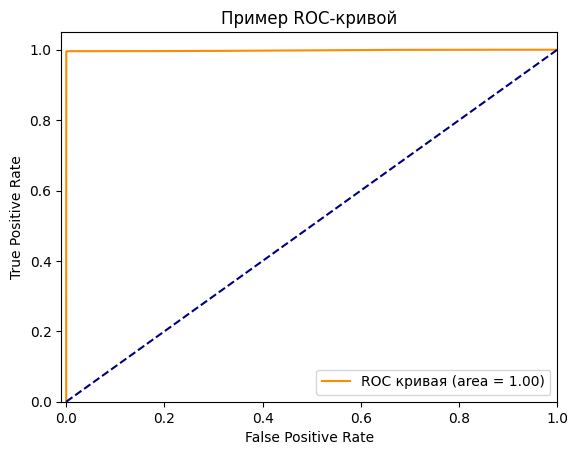

In [88]:
from matplotlib import pyplot as plt

plt.plot(FPR, TPR, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [26]:
class DatasetTrain(Dataset):
    def __init__(self, list_imgs, img_dir, labels):
        self.list_imgs = list_imgs
        self.img_dir = img_dir
        self.labels = labels
        self.transform = trans.Compose([trans.ToTensor(),
                                        trans.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

    def __len__(self):
        return len(self.list_imgs)

    def __getitem__(self, index):
        img_filename_1 = self.img_dir+self.list_imgs[index]
        cv_img_1 = cv2.imread(img_filename_1)
        cv_img_1 = cv2.cvtColor(cv_img_1, cv2.COLOR_BGR2RGB)
        cv_img_1 = self.transform(cv_img_1)
        label = self.labels[index]

        output = {
            'IMG_1_NAME':self.list_imgs[index],
            'IMG_1':cv_img_1,
            'LABEL':label
            }
        return output


In [37]:
def create_train_list(path):
    tmp = os.listdir(path)
    list_imgs = []
    labels = []
    for t in tmp:
        tmp_tmp = os.listdir(path+t)
        for tt in tmp_tmp:
            #if os.path.isdir(path+t+'/'+tt):
            list_imgs.append(t+'/'+tt)
            labels.append(t)
    le = preprocessing.LabelEncoder()
    labels_new = le.fit_transform(labels)
    num_calsses = len(le.classes_)
    return list_imgs, labels_new, num_calsses

In [38]:
list_imgs, labels_new, num_calsses = create_train_list('/data/dev_5/beybars/face_rec/personal_arcFace/data/cropped_2/cropped_alligned_train/')

In [40]:
num_calsses

1924

In [32]:
len(labels_new)

88462

In [34]:
len(list_imgs)

88462

In [41]:
ds = DatasetTrain(list_imgs, '/data/dev_5/beybars/face_rec/personal_arcFace/data/cropped_2/cropped_alligned_train/', labels_new)

In [52]:
train_loader = DataLoader(ds, batch_size=95, shuffle=False)          

In [51]:
len(train_loader)

233

In [57]:
100%25

0

In [69]:
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input)

target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
output = loss(input, target)
print(output)
output.backward()
print()
print(input.grad)
print(output)


tensor([[-0.5991,  0.6142,  0.3017,  0.2814, -0.9649],
        [-1.4914,  0.7996,  0.0508, -1.3391,  1.1146],
        [-2.7230,  0.3357, -1.2446, -2.6732, -0.0811]], requires_grad=True)
tensor([2, 0, 0])
tensor(2.8458, grad_fn=<NllLossBackward0>)

tensor([[ 0.0336,  0.1129, -0.2507,  0.0810,  0.0233],
        [-0.3223,  0.1089,  0.0515,  0.0128,  0.1492],
        [-0.3254,  0.1700,  0.0350,  0.0084,  0.1120]])
tensor(2.8458, grad_fn=<NllLossBackward0>)


In [134]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        print(x.shape)
        x = self.linear1(x)
        print(x.shape)
        x = self.activation(x)
        x = self.linear2(x)
        print(x.shape)
        x = self.softmax(x)
        print(x.shape)
        return x

tinymodel = TinyModel()

In [135]:
a = tinymodel(torch.rand(200,100))
a.shape

torch.Size([200, 100])
torch.Size([200, 200])
torch.Size([200, 10])
torch.Size([200, 10])


/tmp/ipykernel_39697/380898572.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


torch.Size([200, 10])

In [196]:
class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 10),
            torch.nn.Softmax()
        )

    def forward(self, x):
        x=self.seq(x)
        return x

tinymodel = TinyModel()

In [195]:
a = tinymodel(torch.rand(200,100))
a

tensor([[0.0874, 0.1135, 0.0810,  ..., 0.1005, 0.0996, 0.1065],
        [0.0927, 0.1172, 0.0981,  ..., 0.0893, 0.1007, 0.0988],
        [0.0833, 0.1020, 0.0844,  ..., 0.0965, 0.1103, 0.1072],
        ...,
        [0.0937, 0.1191, 0.0927,  ..., 0.0998, 0.0970, 0.1067],
        [0.0914, 0.1074, 0.0878,  ..., 0.1008, 0.0971, 0.0998],
        [0.1039, 0.1057, 0.0859,  ..., 0.1032, 0.0921, 0.1066]],
       grad_fn=<SoftmaxBackward0>)

In [197]:
for n, p in tinymodel.named_parameters():
    print(n, p.shape)
    print(p)
    print()

seq.0.weight torch.Size([200, 100])
Parameter containing:
tensor([[ 0.0067,  0.0833,  0.0607,  ..., -0.0700, -0.0266,  0.0903],
        [-0.0087, -0.0766,  0.0153,  ...,  0.0362,  0.0976, -0.0320],
        [-0.0274,  0.0902,  0.0409,  ...,  0.0529, -0.0202, -0.0013],
        ...,
        [-0.0455, -0.0669,  0.0239,  ...,  0.0474,  0.0215, -0.0670],
        [ 0.0186, -0.0251,  0.0194,  ...,  0.0096,  0.0849, -0.0561],
        [ 0.0588, -0.0748, -0.0754,  ..., -0.0988, -0.0120,  0.0899]],
       requires_grad=True)

seq.0.bias torch.Size([200])
Parameter containing:
tensor([ 0.0884, -0.0443, -0.0094, -0.0099, -0.0586,  0.0126, -0.0594, -0.0893,
        -0.0407, -0.0190,  0.0260, -0.0984,  0.0128, -0.0581, -0.0061,  0.0115,
        -0.0408,  0.0348, -0.0031,  0.0544,  0.0057, -0.0303, -0.0416, -0.0494,
        -0.0440,  0.0569, -0.0948,  0.0326, -0.0449, -0.0026, -0.0381,  0.0156,
         0.0473,  0.0523, -0.0989,  0.0098,  0.0385, -0.0263, -0.0054,  0.0696,
        -0.0301, -0.0453,  0.

In [206]:
optimizer = torch.optim.SGD(tinymodel.parameters(), lr=0.1, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [192]:
optimizer.state_dict()['state'][0]['momentum_buffer'].shape

KeyError: 0

In [164]:
optimizer.state_dict()['param_groups']

[{'lr': 0.01,
  'momentum': 0.9,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'params': [0, 1, 2, 3]}]

In [181]:
tinymodel.seq[0].weight[0,:10]

tensor([ 0.0793, -0.0847, -0.0111, -0.0102,  0.0048,  0.0402, -0.0271,  0.0024,
         0.0522,  0.0632], grad_fn=<SliceBackward0>)

In [207]:
input = torch.randn(200, 100, requires_grad=True)
loss_fn = torch.nn.CrossEntropyLoss()
target = torch.empty(200, dtype=torch.long).random_(5)


for i in range(3):
    optimizer.zero_grad()
    output = tinymodel(input)
    loss = loss_fn(output, target)
    
    loss.backward()
    print(tinymodel.seq[0].weight[0,:10])
    print(loss)
    #print(tinymodel.seq[0].weight[0,:10])
    print(tinymodel.seq[0].weight.grad[0,:10])
    print()
    optimizer.step()

tensor([ 0.0041,  0.0878,  0.0599, -0.0899,  0.0134,  0.0371,  0.0643, -0.0292,
         0.0439, -0.0090], grad_fn=<SliceBackward0>)
tensor(2.2159, grad_fn=<NllLossBackward0>)
tensor([-3.5434e-04,  6.7762e-05,  1.5425e-04, -4.2033e-04, -1.6688e-04,
         2.8904e-04, -2.3796e-05, -3.2430e-04,  2.9211e-04,  2.8192e-04])

tensor([ 0.0041,  0.0877,  0.0599, -0.0898,  0.0134,  0.0370,  0.0643, -0.0292,
         0.0439, -0.0090], grad_fn=<SliceBackward0>)
tensor(2.2152, grad_fn=<NllLossBackward0>)
tensor([-3.5538e-04,  6.8213e-05,  1.5478e-04, -4.2378e-04, -1.6746e-04,
         2.8419e-04, -2.5302e-05, -3.2423e-04,  2.9604e-04,  2.8737e-04])

tensor([ 0.0042,  0.0877,  0.0599, -0.0898,  0.0134,  0.0370,  0.0643, -0.0291,
         0.0438, -0.0091], grad_fn=<SliceBackward0>)
tensor(2.2140, grad_fn=<NllLossBackward0>)
tensor([-3.5739e-04,  6.9128e-05,  1.5578e-04, -4.3047e-04, -1.6858e-04,
         2.7479e-04, -2.8144e-05, -3.2412e-04,  3.0358e-04,  2.9789e-04])



In [227]:
a=torch.Tensor([1,2,3])
a

tensor([1., 2., 3.])

In [228]:
b=torch.Tensor([1,2,3])
b

tensor([1., 2., 3.])

In [238]:
c = torch.zeros((1))
c

tensor([0.])

In [242]:
d=(a==b).sum()
d

tensor(3)

In [243]:
(c+d).shape

torch.Size([1])

In [229]:
a+b

tensor([2., 4., 6.])

In [225]:
torch.zeros((1)).dtype

torch.float32

In [15]:
ad = os.listdir('/data/dev_5/beybars/face_rec/personal_arcFace/data/cropped_2/cropped_alligned_train')

In [16]:
for a in ad:
    listPath = os.listdir('/data/dev_5/beybars/face_rec/personal_arcFace/data/cropped_2/cropped_alligned_train'+'/'+a)
    for aa in listPath:
        if os.path.isdir('/data/dev_5/beybars/face_rec/personal_arcFace/data/cropped_2/cropped_alligned_train'+'/'+a+'/'+aa):
            print('/data/dev_5/beybars/face_rec/personal_arcFace/data/cropped_2/cropped_alligned_train'+'/'+a+'/'+aa)

In [2]:
img = cv2.imread('data/celeba/train/8659/187912.jpg')

In [3]:
img

array([[[119, 126, 119],
        [121, 128, 121],
        [107, 114, 111],
        ...,
        [134, 106, 105],
        [134, 107, 103],
        [134, 107, 103]],

       [[122, 130, 123],
        [ 84,  91,  86],
        [ 74,  83,  80],
        ...,
        [135, 107, 106],
        [134, 107, 103],
        [134, 107, 103]],

       [[ 71,  83,  77],
        [ 67,  79,  73],
        [116, 127, 124],
        ...,
        [132, 107, 105],
        [134, 107, 103],
        [134, 107, 103]],

       ...,

       [[ 90, 106, 129],
        [103, 120, 141],
        [107, 124, 143],
        ...,
        [148, 151, 165],
        [145, 151, 164],
        [144, 150, 163]],

       [[ 84, 103, 124],
        [ 99, 118, 139],
        [103, 123, 141],
        ...,
        [149, 152, 166],
        [146, 151, 166],
        [145, 150, 165]],

       [[ 88, 107, 128],
        [102, 121, 142],
        [105, 125, 143],
        ...,
        [150, 153, 167],
        [146, 151, 166],
        [145, 150, 165]]

In [7]:
le = preprocessing.LabelEncoder()
labels_new = le.fit_transform(['23','23', '564', '564', '555', '564'])

In [8]:
labels_new

array([0, 0, 2, 2, 1, 2])

In [16]:
torch.tensor([0,1,2,3], dtype=torch.long)

torch.int64

In [18]:
t1 = torch.rand((5,512))
t2 = torch.rand((5,512))

In [20]:
diff = np.subtract(t1, t2)
diff.shape

torch.Size([5, 512])

In [31]:
np.square(diff)[0].sum()

tensor(85.7096)

In [29]:
dist = np.square(diff).sum(axis=1)
dist

tensor([85.7096, 85.7546, 83.2996, 90.2393, 88.7972])

In [23]:
np.sum([[0, 1], [0, 5]], axis=1)

array([1, 5])

In [33]:
np.sum(np.logical_and(np.array([True, True, False]), np.array([True, False, False])))

1

In [47]:
a = torch.tensor([0, 0, 0, 0, 0], dtype=torch.uint8)
a

tensor([0, 0, 0, 0, 0], dtype=torch.uint8)

In [48]:
a = torch.tensor(a, dtype=torch.bool)
a

/tmp/ipykernel_484827/1936017203.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a, dtype=torch.bool)


tensor([False, False, False, False, False])

In [43]:
a = torch.tensor([0, 0, 0, 0, 0], dtype=torch.bool)
a = a.numpy()
a

array([False, False, False, False, False])

In [44]:
b = np.array([True, True, False, False, False])
b

array([ True,  True, False, False, False])

In [45]:
np.sum(np.logical_and(a, b))

0

In [1]:
[1,2,3] + [65,35,75]

[1, 2, 3, 65, 35, 75]

In [2]:
from models import Backbone

In [21]:
model_152 = Backbone(152, 0.5, 'ir_se')

In [5]:
model_50 = Backbone(50, 0.5, 'ir_se')

In [22]:
for name, param in model_152.named_parameters():
    print(name, param)
    break

input_layer.0.weight Parameter containing:
tensor([[[[-0.1499, -0.1135, -0.1518],
          [-0.1037,  0.1264, -0.1843],
          [-0.0067, -0.0064, -0.0406]],

         [[ 0.0662, -0.1525, -0.1288],
          [ 0.0385,  0.0722, -0.1723],
          [ 0.0490,  0.1560, -0.1194]],

         [[ 0.1589, -0.1903,  0.0717],
          [ 0.1408, -0.0576, -0.1536],
          [ 0.0274, -0.0644,  0.0039]]],


        [[[ 0.1731, -0.1853,  0.0162],
          [ 0.0660,  0.1052,  0.1485],
          [-0.1000, -0.1134, -0.1515]],

         [[ 0.1476, -0.1245, -0.1483],
          [-0.0646,  0.0594,  0.0222],
          [-0.1542,  0.0461, -0.0857]],

         [[ 0.1836,  0.1339,  0.1828],
          [-0.0229,  0.0636, -0.0589],
          [-0.1645,  0.1896,  0.0641]]],


        [[[-0.1671, -0.1235,  0.1093],
          [ 0.0375,  0.0527,  0.0293],
          [ 0.1553, -0.1402, -0.0672]],

         [[-0.0559,  0.0889, -0.0155],
          [-0.1256, -0.0691, -0.0757],
          [ 0.1631, -0.0647,  0.0551]],

 

In [23]:
param

Parameter containing:
tensor([[[[-0.1499, -0.1135, -0.1518],
          [-0.1037,  0.1264, -0.1843],
          [-0.0067, -0.0064, -0.0406]],

         [[ 0.0662, -0.1525, -0.1288],
          [ 0.0385,  0.0722, -0.1723],
          [ 0.0490,  0.1560, -0.1194]],

         [[ 0.1589, -0.1903,  0.0717],
          [ 0.1408, -0.0576, -0.1536],
          [ 0.0274, -0.0644,  0.0039]]],


        [[[ 0.1731, -0.1853,  0.0162],
          [ 0.0660,  0.1052,  0.1485],
          [-0.1000, -0.1134, -0.1515]],

         [[ 0.1476, -0.1245, -0.1483],
          [-0.0646,  0.0594,  0.0222],
          [-0.1542,  0.0461, -0.0857]],

         [[ 0.1836,  0.1339,  0.1828],
          [-0.0229,  0.0636, -0.0589],
          [-0.1645,  0.1896,  0.0641]]],


        [[[-0.1671, -0.1235,  0.1093],
          [ 0.0375,  0.0527,  0.0293],
          [ 0.1553, -0.1402, -0.0672]],

         [[-0.0559,  0.0889, -0.0155],
          [-0.1256, -0.0691, -0.0757],
          [ 0.1631, -0.0647,  0.0551]],

         [[ 0.1793, -0

In [17]:
param

Parameter containing:
tensor([[[[ 0.0775,  0.0518,  0.1201],
          [-0.1530, -0.0839,  0.0477],
          [-0.0605, -0.0236, -0.0553]],

         [[ 0.0307, -0.1082,  0.0978],
          [-0.0131, -0.1763,  0.1709],
          [-0.0135,  0.0840, -0.0292]],

         [[ 0.0024,  0.1840, -0.1290],
          [ 0.0498, -0.0859, -0.1329],
          [ 0.1045,  0.1757,  0.0237]]],


        [[[-0.1487,  0.0574, -0.0408],
          [ 0.1684, -0.1633,  0.0081],
          [-0.0961, -0.1461,  0.1166]],

         [[-0.1534, -0.1761,  0.1261],
          [-0.0159,  0.1332,  0.0497],
          [ 0.1055,  0.1008,  0.1867]],

         [[ 0.1787, -0.0421,  0.1237],
          [ 0.0158, -0.0924, -0.1394],
          [ 0.1139,  0.0824, -0.0793]]],


        [[[ 0.1650,  0.0663,  0.0392],
          [ 0.1577, -0.1458,  0.1376],
          [-0.1283,  0.1307,  0.0449]],

         [[-0.1066,  0.0124,  0.1273],
          [ 0.1054, -0.1147, -0.1232],
          [-0.0076, -0.1397,  0.1256]],

         [[-0.1066,  0

In [26]:
import numpy as np

In [28]:
tst = np.random.rand(5,5)
tst

array([[0.05487116, 0.3571734 , 0.70541702, 0.78444567, 0.481968  ],
       [0.58076222, 0.51203435, 0.50082611, 0.66668407, 0.73384853],
       [0.30198868, 0.61321013, 0.06083147, 0.42012282, 0.79811782],
       [0.96800602, 0.01877541, 0.12136246, 0.40466663, 0.90564885],
       [0.75113543, 0.31090119, 0.31540748, 0.76741288, 0.61756497]])

In [31]:
np.argmax(tst, axis=1)

array([3, 4, 4, 0, 3])

In [265]:
import random, shutil

In [280]:
list_ids = os.listdir('/data/beybars_id/img_data/cropped_alligned/')

In [282]:
list_ids = os.listdir('/data/beybars_id/img_data/cropped_alligned_val/')

In [283]:
len(list_ids)

20000

In [275]:
val_ids = random.sample(list_ids, 100000)

In [276]:
len(val_ids)

100000

In [256]:
val_ids[0]

'920425401700'

In [260]:
val_ids[1:10]

['970122400843',
 '910906402167',
 '920924451195',
 '910716302871',
 '801018301978',
 '810218300123',
 '000928500682',
 '031001501440',
 '790102300423']

In [258]:
src = '/data/beybars_id/img_data/cropped_alligned/920425401700/'
dst = '/data/beybars_id/img_data/cropped_alligned_val/'
shutil.move(src, dst)

'/data/beybars_id/img_data/cropped_alligned_val/920425401700'

In [277]:
for i in tqdm(val_ids):
    src = '/data/beybars_id/img_data/cropped_alligned/'+i+'/'
    dst = '/data/beybars_id/img_data/cropped_alligned_extra/'
    shutil.move(src, dst)

100%|██████████| 100000/100000 [04:09<00:00, 401.20it/s]


In [262]:
a=torch.nn.Parameter(torch.FloatTensor(813500, 512))

In [264]:
a.shape

torch.Size([813500, 512])

In [2]:
import torch
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from models import Backbone, Arcface

In [ ]:
model = Backbone(50, 0.6, 'ir_se').to()
head = Arcface(embedding_size=512, classnum=self.class_num).to(conf.device)

In [4]:
import numpy as np

In [5]:
thresholds = np.arange(0, 2, 0.01)

In [6]:
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [9]:
indx=np.where(thresholds == 1.47)
indx[0].item()
# ind = indx[]

147